In [1]:
# Neural Network code

### Data cleaning and preprocessing

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import pandas as pd
from nba_api.stats.endpoints import shotchartdetail
import tensorflow as tf
import tensorflow.keras as keras

pd.set_option('display.max_columns', None)  

seasons = [
    '2016-17', '2017-18', '2018-19',
    '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'
]

def find_player(player_id):
    for season in seasons:
        shots = shotchartdetail.ShotChartDetail(
            team_id=0,
            player_id=player_id,  
            season_type_all_star='Regular Season',
            context_measure_simple='FGA',
            season_nullable=season
        ).get_data_frames()[0]
        shots['SEASON'] = season
        if 'shots_df' not in locals():
            shots_df = shots
        else:
            shots_df = pd.concat([shots_df, shots], ignore_index=True)
    return shots_df

curry = find_player(201939)
df = curry[['PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'ACTION_TYPE', 'LOC_X','LOC_Y', 'SHOT_MADE_FLAG', 'HTM', 'VTM']].copy()
df['Time_remaining'] = df['MINUTES_REMAINING'] * 60 + df['SECONDS_REMAINING']
df['Opponent'] = np.where(df['HTM']  == 'GSW', df['VTM'], df['HTM'])
df['Home'] = np.where(df['HTM'] == 'GSW', 1, 0)
df = df.drop(columns=['MINUTES_REMAINING', 'SECONDS_REMAINING', 'HTM', 'VTM'])
df


,PERIOD,ACTION_TYPE,LOC_X,LOC_Y,SHOT_MADE_FLAG,Time_remaining,Opponent,Home
0,1,Jump Shot,130,257,0,542,SAS,1
1,1,Step Back Jump shot,189,174,1,486,SAS,1
2,1,Jump Shot,159,229,0,143,SAS,1
3,1,Jump Shot,163,141,0,121,SAS,1
4,2,Jump Shot,-9,267,1,407,SAS,1
...,...,...,...,...,...,...,...,...
8890,4,Step Back Jump shot,129,243,1,19,OKC,0
8891,4,Pullup Jump shot,-4,290,0,0,OKC,0
8892,5,Jump Shot,1,294,1,237,OKC,0
8893,5,Driving Floating Jump Shot,70,142,1,147,OKC,0


In [3]:
X = pd.get_dummies(df.drop(columns=['SHOT_MADE_FLAG']), columns=['ACTION_TYPE', 'Opponent'])
X = X.astype('float32')  
y = df['SHOT_MADE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y.value_counts(normalize=True)

SHOT_MADE_FLAG
0    0.53131
1    0.46869
Name: proportion, dtype: float64

## Neural Network

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weights_dict = dict(enumerate(weights))

def build_model(hidden_layers = [64,  32], dropout_rate=0.2):
    model = keras.Sequential()
    model.add(keras.layers.Dense(hidden_layers[0], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dropout(dropout_rate))

    if len(hidden_layers) > 1:
        for units in hidden_layers[1:]:
            model.add(keras.layers.Dense(units, activation='relu'))
            model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(1, activation='sigmoid'))  
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model = build_model, verbose=0, class_weight=weights_dict)
param_grid = {
    'model__hidden_layers': [[64], [32,16], [64, 32], [128, 64]],
    'model__dropout_rate': [0.1, 0.2, 0.3],
    'batch_size': [16, 32, 64],
    'epochs': [20, 30, 40]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

print(f'Best Parameters: {random_search.best_params_}')
print(f'Best Accuracy Score: {random_search.best_score_}')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Owner\OneDrive\Documents\GitHub\NBA-Actions\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Owner\OneDrive\Documents\GitHub\NBA-Actions\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Owner\OneDrive\Documents\GitHub\NBA-Actions\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the fi

Best Parameters: {'model__hidden_layers': [64], 'model__dropout_rate': 0.2, 'epochs': 20, 'batch_size': 16}
Best Accuracy Score: 0.5708263069139967


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
              precision    recall  f1-score   support

           0       0.61      0.51      0.56       956
           1       0.53      0.63      0.57       823

    accuracy                           0.57      1779
   macro avg       0.57      0.57      0.57      1779
weighted avg       0.57      0.57      0.57      1779



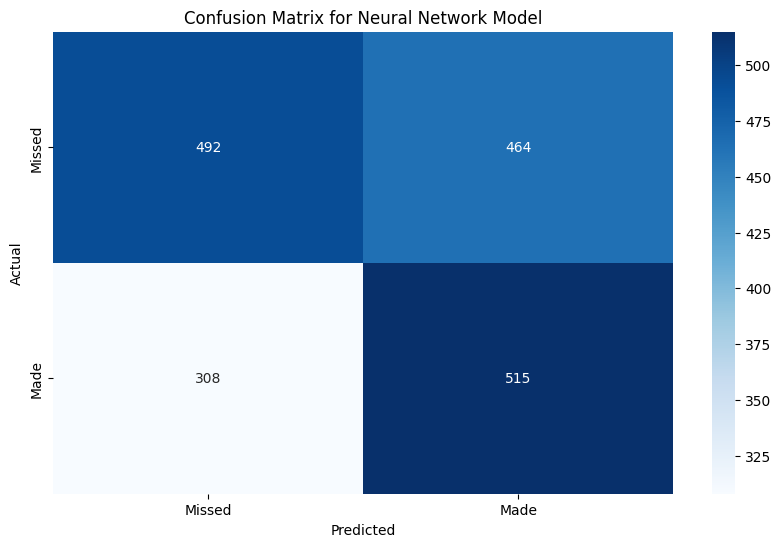

In [5]:
best_model = random_search.best_estimator_.model_
y_pred_probs = best_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Neural Network Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Random Forests

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {'n_estimators': [50, 100, 200], 
              'max_depth': [None, 10, 20, 30], 
              'min_samples_split': [2, 5, 10]}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f'Best Random Forest Parameters: {grid_search.best_params_}')
print(f'Best Random Forest Accuracy Score: {grid_search.best_score_}')

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best Random Forest Accuracy Score: 0.5990725126475548


              precision    recall  f1-score   support

           0       0.59      0.63      0.61       956
           1       0.53      0.48      0.51       823

    accuracy                           0.56      1779
   macro avg       0.56      0.56      0.56      1779
weighted avg       0.56      0.56      0.56      1779



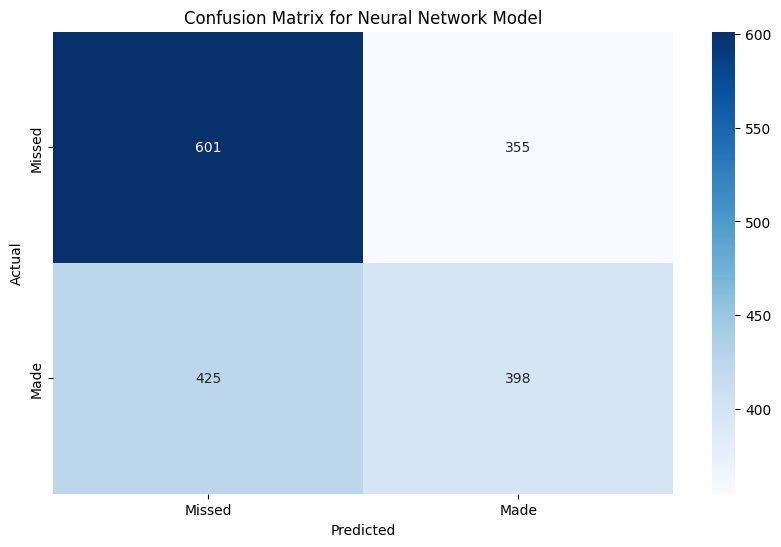

In [7]:
rf_best = grid_search.best_estimator_
y_pred = (rf_best.predict(X_test > 0.485)).astype(int)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Neural Network Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## XGboost

c:\Users\Owner\OneDrive\Documents\GitHub\NBA-Actions\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:27:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.59      0.59       956
           1       0.52      0.51      0.51       823

    accuracy                           0.55      1779
   macro avg       0.55      0.55      0.55      1779
weighted avg       0.55      0.55      0.55      1779



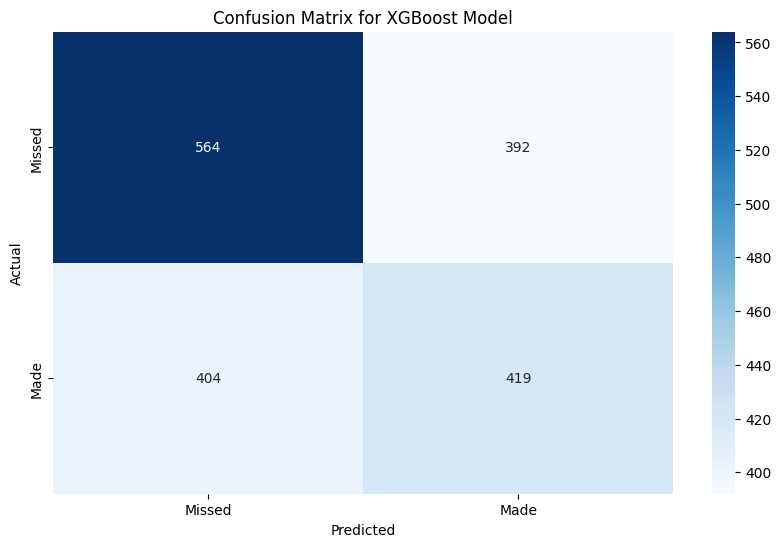

In [8]:
from xgboost import XGBClassifier

scale = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, xgb_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for XGBoost Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Logistic Regression

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       956
           1       0.54      0.51      0.52       823

    accuracy                           0.57      1779
   macro avg       0.57      0.57      0.57      1779
weighted avg       0.57      0.57      0.57      1779



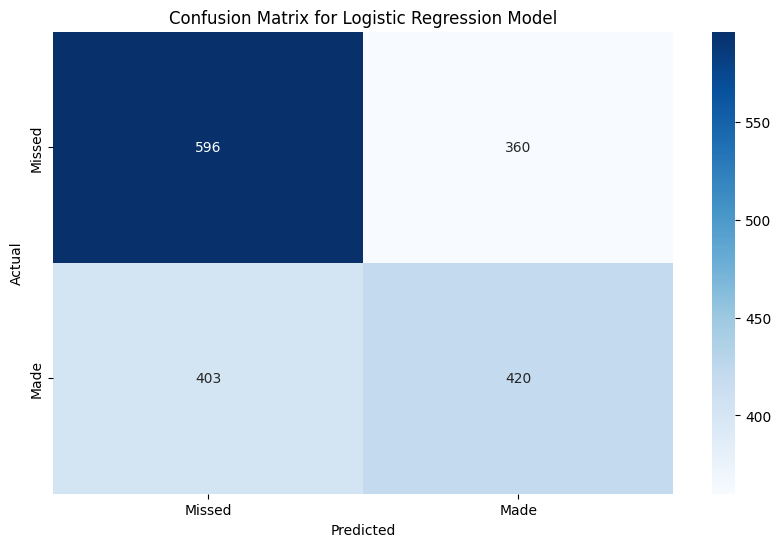

In [9]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
lg.fit(X_train, y_train)
lg_predictions = lg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lg_predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, lg_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Logistic Regression Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Feature Engineering & Selection to improve accuracy

C:\Users\Owner\AppData\Local\Temp\ipykernel_25992\2687290281.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Score', data=scores.head(20), palette='viridis')


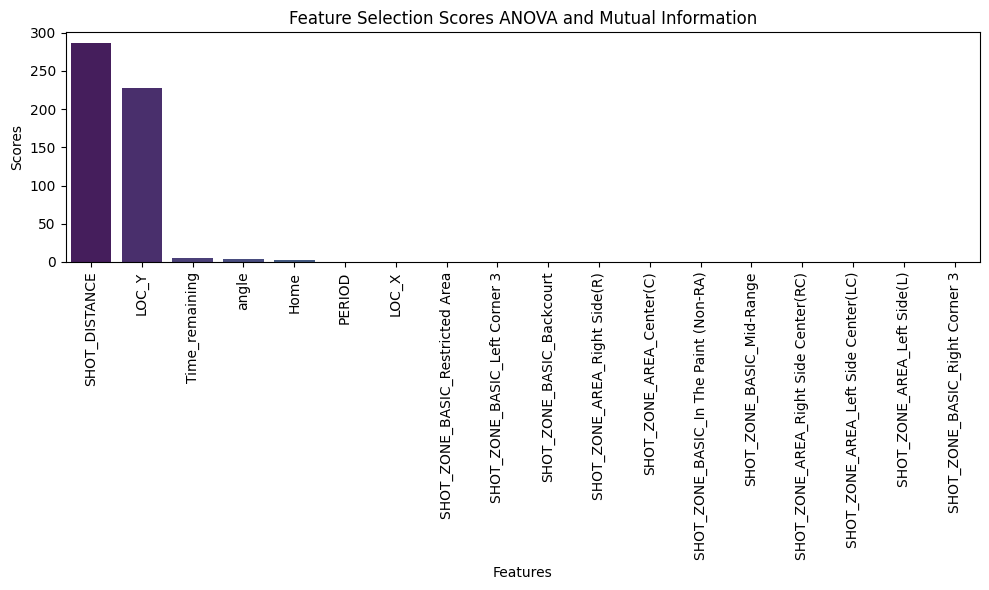

In [10]:

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

curry_df = curry[['PERIOD', 'MINUTES_REMAINING', 'SHOT_ZONE_AREA',
       'SECONDS_REMAINING', 'SHOT_ZONE_BASIC', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'HTM', 'VTM', 'SHOT_MADE_FLAG']].copy()
curry_df['Time_remaining'] = curry_df['MINUTES_REMAINING'] * 60 + curry_df['SECONDS_REMAINING']
curry_df['Home'] = np.where(curry_df['HTM'] == 'GSW', 1, 0)
curry_df['angle'] = np.arctan2(curry_df['LOC_Y'], curry_df['LOC_X']) * (180 / np.pi)
curry_df = curry_df.drop(columns=['MINUTES_REMAINING', 'SECONDS_REMAINING', 'HTM', 'VTM'])

X = curry_df.drop(columns=['SHOT_MADE_FLAG'])
y = curry_df['SHOT_MADE_FLAG']

numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

selector_num = SelectKBest(score_func=f_classif, k='all')
selector_num.fit(X[numeric_features], y)
selected_num_features = numeric_features[selector_num.get_support()]
num_scores = selector_num.scores_[selector_num.get_support()]

X_cat_encoded = pd.get_dummies(X[categorical_features], drop_first=True)
selector_cat = SelectKBest(score_func=mutual_info_classif, k='all')
selector_cat.fit(X_cat_encoded, y)
selected_cat_features = X_cat_encoded.columns[selector_cat.get_support()]
cat_scores = selector_cat.scores_[selector_cat.get_support()]

X_selected = pd.concat([X[selected_num_features].reset_index(drop=True), 
                        X_cat_encoded[selected_cat_features].reset_index(drop=True)], axis=1)

scores = pd.DataFrame({
    'Feature': list(selected_num_features) + list(selected_cat_features),
    'Score': list(num_scores) + list(cat_scores)
}).sort_values(by='Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Score', data=scores.head(20), palette='viridis')
plt.title('Feature Selection Scores ANOVA and Mutual Information')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Scores')
plt.tight_layout()
plt.show()

### NN After Feature Selection

In [11]:
X = X_selected.astype('float32')  
y = df['SHOT_MADE_FLAG']

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weights_dict = dict(enumerate(weights))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=40, batch_size=32, validation_split=0.2, class_weight=weights_dict)
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/40


c:\Users\Owner\OneDrive\Documents\GitHub\NBA-Actions\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5503 - loss: 0.6890 - val_accuracy: 0.5562 - val_loss: 0.6778
Epoch 2/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5819 - loss: 0.6753 - val_accuracy: 0.5716 - val_loss: 0.6748
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5794 - loss: 0.6736 - val_accuracy: 0.5499 - val_loss: 0.6817
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5805 - loss: 0.6724 - val_accuracy: 0.5801 - val_loss: 0.6755
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5689 - loss: 0.6731 - val_accuracy: 0.5843 - val_loss: 0.6742
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5878 - loss: 0.6673 - val_accuracy: 0.5758 - val_loss: 0.6753
Epoch 7/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5782 - loss: 0.6685 - val_accuracy: 0.5681 - val_loss: 0.6772
Epoch 8/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5919 - loss: 0.6705 - val_accuracy: 0.5667 - val_

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
              precision    recall  f1-score   support

           0       0.58      0.53      0.56       956
           1       0.50      0.55      0.53       823

    accuracy                           0.54      1779
   macro avg       0.54      0.54      0.54      1779
weighted avg       0.55      0.54      0.54      1779



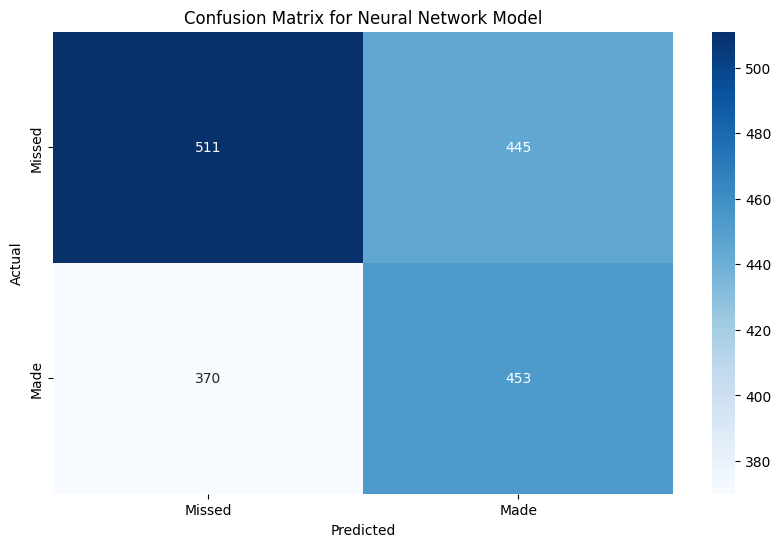

In [12]:
predictions = (model.predict(X_test_scaled) > 0.485).astype(int)
print(classification_report(y_test, predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Neural Network Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()